In [1]:
import numpy as np
import cv2
from time import time
from time import sleep
from matplotlib import pyplot as plt

class Camera():

    def __init__(self, cap_id):
        self._cap = cv2.VideoCapture(cap_id)
        assert self._cap.isOpened(), f'can not connect to camera with id {cap_id}'
        

    def run(self, stop_event, outque):
        time_out = time()
        print('start polling frames')
        while not stop_event.is_set():
            try:
                ret, frame = self._cap.read()
                outque.put([frame, time()])
                #print(time() - time_out, end = '        \r')
                if outque.full():
                    frame_out, time_out = outque.get()
            except KeyboardInterrupt:
                pass
             
        self._cap.release()
        print()
        print(f'frames polling stopped               {not self._cap.isOpened()}',)

In [2]:
# %load_ext autoreload
# %autoreload 2
    
import cv2
import numpy as np
import os
from time import sleep, time
from sklearn.cluster import DBSCAN
from scipy.spatial.transform import Rotation as R

from threading import Event, Thread, Lock
from queue import Queue

from multiprocessing import Process
from multiprocessing import Event as PEvent
from multiprocessing import Queue as PQueue

from adafruit_bno08x.i2c import BNO08X_I2C
from adafruit_bno08x import BNO_REPORT_LINEAR_ACCELERATION, BNO_REPORT_ACCELEROMETER, BNO_REPORT_GYROSCOPE, BNO_REPORT_MAGNETOMETER, BNO_REPORT_GRAVITY, BNO_REPORT_ROTATION_VECTOR
import busio




def pt2h(abs_pressure, temperature, P0):    
    return (1 - abs_pressure/P0) * 8.3144598 * (273.15 + temperature/100) / 9.80665 / 0.0289644
    

# Processes
pstop = PEvent()

# run camera polling
vidque = PQueue(2)
vcap = Camera(0)
video_poll_process = Process(target=vcap.run, args=(pstop, vidque, ))
video_poll_process.start()


start polling frames


In [3]:
from math import sqrt, atan2, pi
import math
def find_roll(dqw, dqx, dqy, dqz):
    norm = sqrt(dqw * dqw + dqx * dqx + dqy * dqy + dqz * dqz)
    dqw = dqw / norm
    dqx = dqx / norm
    dqy = dqy / norm
    dqz = dqz / norm
    sinr_cosp = +2.0 * (dqw * dqx + dqy * dqz)
    cosr_cosp = +1.0 - 2.0 * (dqx * dqx + dqy * dqy)
    roll_raw = atan2(sinr_cosp, cosr_cosp)
    roll = roll_raw * 180.0 / pi
    if roll > 0:
        roll = 360 - roll
    else:
        roll = abs(roll)
    return roll

def find_pitch(dqw, dqx, dqy, dqz):
    norm = sqrt(dqw * dqw + dqx * dqx + dqy * dqy + dqz * dqz)
    dqw = dqw / norm
    dqx = dqx / norm
    dqy = dqy / norm
    dqz = dqz / norm
    sinp = sqrt(+1.0 + 2.0 * (dqw * dqy - dqx * dqz))
    cosp = sqrt(+1.0 - 2.0 * (dqw * dqy - dqx * dqz))
    pitch_raw = +2.0 * atan2(sinp, cosp) - (pi / 2.0)
    pitch = pitch_raw * 180.0 / pi
    if pitch > 0:
        pitch = 360 - pitch
    else:
        pitch = abs(pitch)
    return pitch

i2c = busio.I2C((1, 14), (1, 15))
device = BNO08X_I2C(i2c, address=0x4b)
for feature in [BNO_REPORT_ACCELEROMETER, BNO_REPORT_GYROSCOPE, BNO_REPORT_MAGNETOMETER, BNO_REPORT_ROTATION_VECTOR]:
    device.enable_feature(feature)
    
imu_stop = PEvent()
imu_que = PQueue(2)

def run_imu(device, ev, que):
    time_out = time()
    print('start polling imu values')
    while not ev.is_set():
        try:
            q = device.quaternion
            que.put([q, time()])
            if que.full():
                q, time_out = que.get()
        except KeyboardInterrupt:
            pass
    print("imu polling stopped")

imu_poll_process = Process(target=run_imu, args=(device, imu_stop, imu_que,))
imu_poll_process.start()

start polling imu values


# Cam check

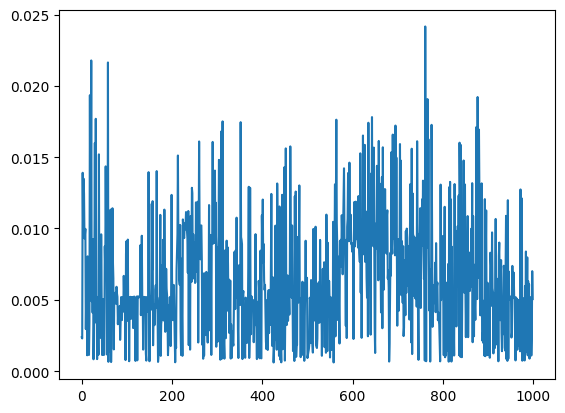

In [4]:
intervals_cam = []
intervals_imu = []

for i in range(1000):
    frame, tic_f = vidque.get()
    intervals_cam.append(tic_f)
    q, tic_q = imu_que.get()
    intervals_imu.append(tic_q)

from matplotlib import pyplot as plt
plt.plot(np.abs(np.array(intervals_cam) - np.array(intervals_imu)))

In [5]:
from IPython.display import display as IPdisplay, Image as IPImage

display_handle=IPdisplay(None, display_id=True)
try:
    while True:
        frame = vidque.get()[0]
        # _, frame = video.read()
        frame = cv2.flip(frame, 1)
        # print(frame.shape, type(frame))
        _, frame = cv2.imencode('.jpeg', frame)
        display_handle.update(IPImage(data=frame.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    display_handle.update(None)

None

# Camera main

In [6]:
CaM = np.asarray([
    [360., 0, 320.],              
    [0, 360., 240.], 
    [0, 0, 1.]
])

CaM = np.array([[628.07730444,   0.        , 296.22347846],
       [  0.        , 624.87736912, 280.1399009 ],
       [  0.        ,   0.        ,   1.        ]])

from IPython.display import display as IPdisplay, Image as IPImage

display_handle=IPdisplay(None, display_id=True)
try:
    while True:
        frame, time_f = vidque.get()   
        q, tic_r = imu_que.get()
        
        tan_x = np.tan(-math.radians(find_pitch(q[3], q[0], q[1], q[2])))
        tan_y = np.tan(-math.radians(find_roll(q[3], q[0], q[1], q[2])))


        dpp = np.asarray([
            tan_x*CaM[0,0] + CaM[0,2],
            tan_y*CaM[1,1] + CaM[1,2],
        ])

        cv2.circle(frame, dpp.astype(np.int32).tolist(), 8, (0, 0, 255), -1)
        # print(frame.shape)
        # frame = cv2.resize(frame, (160, 120))
        
        _, frame = cv2.imencode('.jpeg', frame)
        display_handle.update(IPImage(data=frame.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    display_handle.update(None)

None

# Checkboard calib

In [214]:
frames = []


In [133]:
# frame, time_f = vidque.get()
# frame = cv2.cvtColor(frame, cv.COLOR_BGR2GRAY)
# ret, corners = cv.findChessboardCorners(frame, (4,6), None)
# print(ret)
# if ret:
#     print(len(frames))
#     frames.append(frame)
# # plt.imshow(frame)

False


In [215]:
while len(frames) < 30:
    frame, time_f = vidque.get()
    gray = cv2.cvtColor(frame, cv.COLOR_BGR2GRAY)
    ret, corners = cv.findChessboardCorners(frame, (4,6), None)
    if ret:
        print(len(frames))
        frames.append(frame)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [216]:
import numpy as np
import cv2 as cv
# import glob
frames_post = []
grays = []
 
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
 
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

mm = 13.

# objp = np.zeros((6*7,3), np.float32)
# lst = []
# for i in range(10):
#     lst = lst + [(0.,i,0.), (1.,i,0.), (2.,i,0.),(3.,i,0.), (4., i, 0.), (5., i, 0.), (6., i, 0.), (7., i, 0.), (8., i, 0.), (9., i, 0.)]
#     # lst.append(lstt)
# objp = np.array(lst)
lst = []
for j in range(4):
    lst_ = []
    for i in range(6):
        lst_ = lst_ + [np.array((j*mm, i*mm, 0.), dtype=np.float32)]
    lst = lst + lst_.copy()
    # lst.append(lstt)
# print(lst)
objp = np.array(lst)
print(objp.shape)
# objp = np.array([(0.,0.,0.), (1.,0.,0.), (2.,0.,0.),(3.,0.,0.), (4., 0., 0.), (5., 0., 0.), (6., 0., 0.)])
objp[:,:2] = np.mgrid[0:4,0:6].T.reshape(-1,2)
 
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
 
# images = glob.glob('*.jpg')
 
for frame in frames:
    # img = cv.imread(fname)
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (4,6), None)
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        grays.append(gray)
    
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
    
        # Draw and display the corners
        frame_post = np.copy(frame)
        cv.drawChessboardCorners(frame_post, (4,6), corners2, ret)
        frames_post.append(frame_post)
        # cv.imshow('img', img)
        # cv.waitKey(500)
    
    # cv.destroyAllWindows()

(24, 3)


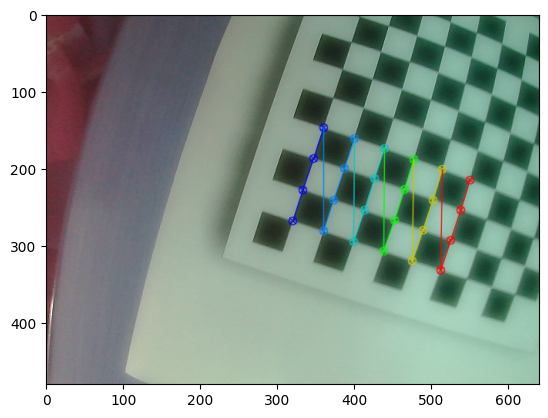

In [217]:
# frames = frames[10:]
plt.imshow(frames_post[-1])

In [218]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, grays[-1].shape[::-1], None, None)


In [219]:
mtx

array([[628.07730444,   0.        , 296.22347846],
       [  0.        , 624.87736912, 280.1399009 ],
       [  0.        ,   0.        ,   1.        ]])

# reload

In [ ]:
imu_stop.set()
pstop.set()
imu_stop.clear()
pstop.clear()
imu_poll_process.join()
video_poll_process.join()
video_poll_process = Process(target=vcap.run, args=(pstop, vidque, ))
video_poll_process.start()
imu_poll_process = Process(target=run_imu, args=(device, imu_stop, imu_que,))
imu_poll_process.start()

In [ ]:
from time import time
import math

from PIL import Image

# BFMatcher with default params
bf = cv2.BFMatcher()

"""
CaM = np.asarray([
    [380.44, 0, 329.3],              
    [0, 379.97, 240.42], 
    [0, 0, 1]
])
"""
CaM = np.asarray([
    [360., 0, 320.],              
    [0, 360., 240.], 
    [0, 0, 1.]
])

NUM_MATCH_PTS_THR = 4
RANSAC_THR = 5.0
RF = 1/4
ET_HEIGHT = 10000 # height in santimeters with known resoltuion per pixel
SM_PER_PIX = 2 # at height = ET_HEIGHT
MOVE_THR = 32

POS_FAIL_THR = 3 

START_ALTITUDE = 10

SHOW = True
HOLD_POS = False
"""
msg = pixque.get()
P0 = msg['SCALED_PRESSURE']['press_abs']
"""

t_frame = None
fail_counter = 0

while not stop.is_set():
    try:
        tic = time()
        
        frame, time_f = vidque.get()   
        q, tic_r = imu_que.get()
        """
        msg = pixque.get()
        
        tic_r = time()
        
        height = pt2h(
            msg['SCALED_PRESSURE']['press_abs'], 
            msg['SCALED_PRESSURE']['temperature'], 
            P0
        )
        """

        """
        tan_x = np.tan(msg['ATTITUDE']['roll'])
        tan_y = np.tan(msg['ATTITUDE']['pitch'])
        """
        tan_x = np.tan(math.radians(find_roll(q[3], q[0], q[1], q[2])))
        tan_y = np.tan(math.radians(find_pitch(q[3], q[0], q[1], q[2])))

        # calculate dpp in camera frame
        dpp = np.asarray([
            tan_x*CaM[0,0] + CaM[0,2],
            tan_y*CaM[1,1] + CaM[1,2],
        ])

        # find keypoints on image        
        tic = time()
        
        gray, kps, uvs, des = det.detect(frame)

        # keypoints visualization 
        if SHOW:
            cv2.circle(frame, dpp.astype(np.int32).tolist(), 8, (0, 0, 255), -1)
            for pt in uvs.astype(np.int32):
                cv2.circle(frame, pt.tolist(), 2, (0, 255, 0), -1)

        # set initial frame with target keypoint
        if t_frame is None or fail_counter>=POS_FAIL_THR:
            t_frame = frame.copy()
            t_des = des
            t_kps = kps
            t_uvs = uvs
            t_dpp = dpp

            # take 200 sm height to avoid negative height due to pressure fluctuations
            sm_per_pix = SM_PER_PIX / ET_HEIGHT * max(height, 200) 

            fail_counter = 0
        
        # start keypoints matching
        matches = bf.knnMatch(t_des, des, k=2)
 
        # Apply ratio test
        good = []
        for m,n in matches:
            if m.distance < 0.75*n.distance:
                good.append([m])
        
        # extract keypoints coordinates in ground frame 
        t_pts = np.float32([ t_kps[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
        pts = np.float32([ kps[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)

        # first get homography matrix for transformation between target and current ground frames
        # then project target dpp to current ground frame  
        try:
            # homography filter
            M, mask = cv2.findHomography(t_pts, pts, cv2.RANSAC, RANSAC_THR)
            
            # clusterng filter
            diffs = (pts - t_pts).reshape(-1,2)
            good_ids = np.where(mask.ravel()==True)[0]
            good_diffs = diffs[good_ids]

            clustering = DBSCAN(eps=RANSAC_THR, min_samples=NUM_MATCH_PTS_THR).fit(good_diffs)
            
            labels, counts = np.unique(clustering.labels_, return_counts=True)
            res_id = None
            for idx in np.argsort(counts)[::-1]:
                if labels[idx]>=0:
                    res_id = idx
                    break
                    
            if res_id is not None:
                best_ids = np.where(clustering.labels_==labels[idx])[0]
                best_ids = good_ids[best_ids]
                best_diffs = diffs[best_ids]                
                t_shift = np.mean(best_diffs, axis=0)
                target_pt = t_dpp + t_shift
                cv2.circle(frame, target_pt.astype(np.int32).tolist(), 8, (255, 0, 0), -1)
                best = [m for ii, m in enumerate(good) if ii in best_ids]
                shift = dpp - target_pt
            else:
                raise Exception('No good matches')         
                
        except Exception as e:
            print(e, end = '     \r')
            best = []
            shift = np.zeros(2)
            fail_counter += 1

        
        if ms.text!='':
            command = ms.text
            print(f'{command}/{HOLD_POS}', end=', ')
            if command=='manual':
                HOLD_POS = False
            elif command=='hold_pos':
                HOLD_POS = True
            elif command in ['up', 'down', 'forward', 'backward', 'right', 'left', 'clock', 'counterclock']:
                pctrl.move(command)
            elif command=='LAND':
                pctrl.set_mode(command)
            elif command=='rtl':
                pctrl.rtl()
            elif command=='take_off':
                pctrl.take_off(START_ALTITUDE)
            elif command=='land by-by':
                pctrl.set_mode('ALT_HOLD')
                sleep(2)
                # prearm
                pctrl.rc_values[2] = pctrl.RC_THROTTLE_LOW
                pctrl.rc_values[:2] = pctrl.RC_NEUTRAL_POS, pctrl.RC_NEUTRAL_POS 
                sleep(2)
                pctrl.arm()
                                
            
            command = ''
        else:
            pctrl.neutral()

        if HOLD_POS:
            dx, dy = np.abs(shift)
            sx, sy = np.sign(shift)
            if dx>MOVE_THR and sx<0:
                pctrl.move('right')
            if dx>MOVE_THR and sx>0:
                pctrl.move('left')
            if dy>MOVE_THR and sy>0:
                pctrl.move('forward')
            if dy>MOVE_THR and sy<0:
                pctrl.move('backward')

            
        img3 = cv2.drawMatchesKnn(t_frame, t_kps, frame, kps, best, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        img3 = cv2.resize(img3, None, fx=RF, fy=RF)
        tic_p = time()
        
        det_que.put(img3)

        #print(f'{1/(time()-tic):.1f},  {(tic_r - tic):.2f},  {(tic_p - tic_r):.2f}', end='                    \r')
        
    except Exception as e:
        print(e)

print('stopping everything')
pstop.set()
stop.set()
sleep(1)
vcap._cap.release()

pctrl.set_mode('LAND')
pctrl.set_mode('LAND')
pctrl.set_mode('LAND')
        

In [ ]:
%load_ext autoreload
%autoreload 2

from detect import Detector

det = Detector()

In [ ]:
det.frame = det.detect(frame)
det.frame.keys()

In [ ]:
def lowe_filter(des_0, des_1, in_mask=None):
        """
        Lowe filter to be applied to SIFT keypoints, N points for each frame
        Args:
            :frame0: - dict with at least 'des' key, Nx128 ndarray
            :frame1: - dict with at least 'des' key, Nx128 ndarray
            :in_mask: - mask of (2, N) shape for points to be processed
        Returns:
            :mask: - ndarray of (2, N) shape with valid keypoints indexes
        """

        num_points = max(len(des_0), len(des_1))
        if in_mask is None:
            in_mask = np.ones((2, num_points), dtype=np.int32)
        in_p_ids = np.where(in_mask[0])[0]
        in_n_ids = np.where(in_mask[1])[0]
        p_des = des_0[in_p_ids]
        n_des = des_1[in_n_ids]
    
        # keypoints matching
        matches = bf.knnMatch(p_des, n_des, k=2)
 
        out_mask = np.zeros_like(in_mask)
    
        # apply ratio test
        match_p_ids = []
        match_n_ids = []
        for m,n in matches:
            if m.distance < 0.75*n.distance:
                print(m.queryIdx, m.trainIdx)
                pid = in_p_ids[m.queryIdx]
                nid = in_n_ids[m.trainIdx]
                out_mask[0, pid] = 1
                out_mask[1, nid] = 1   
        
        return out_mask
    

def homography_filter(kps_0, kps_1, in_mask=None):
        """
        Homography filter for SIFT keypoints
        """
    
        num_points = max(len(kps_0), len(kps_1))
        if in_mask is None:
            in_mask = np.ones((2, num_points), dtype=np.int32)

        in_p_ids = np.where(in_mask[0])[0]
        in_n_ids = np.where(in_mask[1])[0]

        p_pts = np.float32([kp.pt for kp, m in zip(kps_0, in_mask[0]) if m]).reshape(-1,1,2)
        n_pts = np.float32([kp.pt for kp, m in zip(kps_1, in_mask[1]) if m]).reshape(-1,1,2)
        
        M, mask = cv2.findHomography(p_pts, n_pts, cv2.RANSAC, 5.0)

        out_mask = np.zeros_like(in_mask)

        match_ids = np.where(mask)[0]
        out_p_ids = in_p_ids[match_ids]
        out_n_ids = in_n_ids[match_ids]

        out_mask[0, out_p_ids] = 1
        out_mask[1, out_p_ids] = 1

        return out_mask
        

def dbscan_filter(kps_0, kps_1, in_mask=None):
        
        num_points = max(len(kps_0), len(kps_1))
        if in_mask is None:
            in_mask = np.ones((2, num_points), dtype=np.int32)

        in_p_ids = np.where(in_mask[0])[0]
        in_n_ids = np.where(in_mask[1])[0]

        p_pts = np.float32([kp.pt for kp, m in zip(kps_0, in_mask[0]) if m]).reshape(-1,2)
        n_pts = np.float32([kp.pt for kp, m in zip(kps_1, in_mask[1]) if m]).reshape(-1,2)
        

In [ ]:
        kps_0, kps_1 = t_kps, kps

        num_points = max(len(kps_0), len(kps_1))
        if in_mask is None:
            in_mask = np.ones((2, num_points), dtype=np.int32)

        in_p_ids = np.where(in_mask[0])[0]
        in_n_ids = np.where(in_mask[1])[0]

        p_pts = np.float32([kp.pt for kp, m in zip(kps_0, in_mask[0]) if m]).reshape(-1,1,2)[:30]
        n_pts = np.float32([kp.pt for kp, m in zip(kps_1, in_mask[1]) if m]).reshape(-1,1,2)[:30]
        
        M, mask = cv2.findHomography(p_pts, n_pts, cv2.RANSAC, 5.0)

        out_mask = np.zeros_like(in_mask)

        match_ids = np.where(mask)[0]
        out_p_ids = in_p_ids[match_ids]
        out_n_ids = in_n_ids[match_ids]

        out_mask[0, out_p_ids] = 1
        out_mask[1, out_p_ids] = 1



In [ ]:
out_mask

In [ ]:
p_ids = np.where(in_mask[0])[0]
p_ids[np.where(mask)[0]]

In [ ]:
p_ids

In [ ]:
ids = np.asarray([1,3,5,7], dtype=np.int32)

In [ ]:
in_mask.shape, np.where(mask)[0]

In [ ]:
        in_mask = None
        des_0, des_1 = t_des, des
        
        num_points = max(len(des_0), len(des_1))
        if in_mask is None:
            in_mask = np.ones((2, num_points), dtype=np.int32)
        in_p_ids = np.where(in_mask[0])[0]
        in_n_ids = np.where(in_mask[1])[0]
        p_des = des_0[in_p_ids]
        n_des = des_1[in_n_ids]
    
        # keypoints matching
        matches = bf.knnMatch(p_des, n_des, k=2)
 
        out_mask = np.zeros_like(in_mask)
    
        # apply ratio test
        match_p_ids = []
        match_n_ids = []
        for m,n in matches:
            if m.distance < 0.75*n.distance:
                print(m.queryIdx, m.trainIdx)
                pid = in_p_ids[m.queryIdx]
                nid = in_n_ids[m.trainIdx]
                out_mask[0, pid] = 1
                out_mask[1, nid] = 1   
       


In [ ]:
out_mask

In [ ]:
lowe_filter(det.frame['des'], det.frame['des'])

In [ ]:
type(det.frame['des']), det.frame['des'].shape

In [ ]:
vcap._cap.release()
vcap._cap.isOpened()

In [ ]:
from pymavlink import mavutil

# set connection with PixHawk
port = 'udp:127.0.0.1:14551'
master = mavutil.mavlink_connection(port)

master.wait_heartbeat()


In [ ]:
from time import time, sleep

tic = time()
for _ in range(24):
    msg = master.recv_match(blocking=True).to_dict()
    print(msg['mavpackettype'])
    
(time() - tic)/24


In [ ]:
from time import time, sleep

tic = time()
for _ in range(24):
    msg = pixdata._master.recv_match(type='ATTITUDE', blocking=True).to_dict()
    
(time() - tic)/24
